# Exploring the Space of Short Programs
## Using the Universal Iota Combinator

Using the turing-complete zot programming language, we can specify a program using only zeros and ones. Therefore it is possible to literally search the space of programs and look for patterns. An interesting fact is that the shorter the program that generates your observations, the better it generalizes. So I will be looking at the shortest possible programs, and working my way upwards. Maybe we'll find something interesting along the way. 

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import re

import sklearn.datasets as datasets
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image
from IPython.display import display
from sklearn.tree import export_graphviz
import pydotplus

import sys

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

### Non-empty Output Distribution
It turns out that most programs produce no output. The code below graphs the distribution of programs that do produce non-empty output.

Fraction of All Programs: 0.0


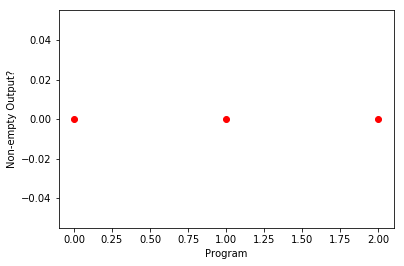

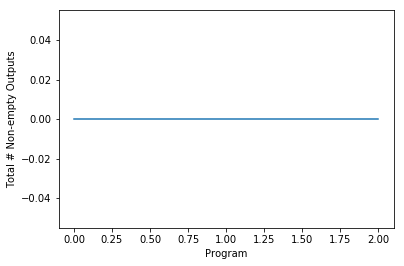

In [2]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(itertools.islice(iterable, n))

@interact(num_samples=(10,1000,100))
def vis_non_empty(num_samples=10):
    with open("export.txt") as f:
        non_empty_indices = list(map(lambda x:x[0], 
                                     filter(lambda x: len(x[1])>0, 
                                            take(num_samples, enumerate(map(lambda x: x.strip(), f))))))
        x_range = range(max(non_empty_indices))
        indicator_range = [1 if x in non_empty_indices else 0 for x in x_range]
        indicator_integral = np.cumsum(indicator_range)
        
        plt.figure()
        plt.xlabel("Program")
        plt.ylabel("Non-empty Output?")
        plt.plot(x_range, indicator_range, 'ro')
        
        plt.figure()
        plt.xlabel("Program")
        plt.ylabel("Total # Non-empty Outputs")
        plt.plot(x_range, indicator_integral)  
        
        print("Fraction of All Programs: "+str(indicator_integral[-1]/len(x_range)))


### Binary Output Distribution
Most programs that produce output actually produce functions. Below I show the distribution of programs that actually output a number.

Fraction of All Programs: 0.0


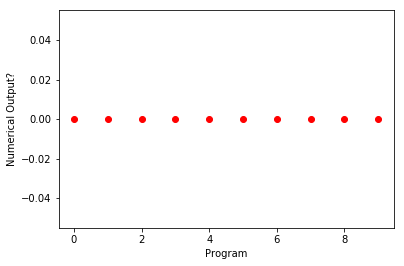

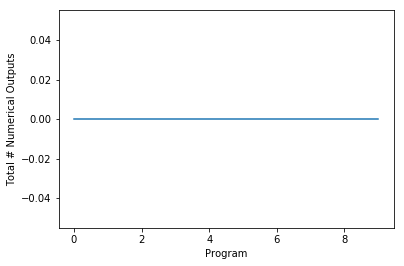

In [4]:
@interact(num_samples=(0,500000,100000))
def vis_all_digits(num_samples=10):
    with open("export.txt") as f:
        binary_outputs = list(map(lambda x:(x[0],int(x[1],2)),
                                  filter(lambda x:x[1].isdigit(), 
                                         enumerate(map(lambda x: x.strip(), f)))))
        binary_output_dict = {x[0]:x[1] for x in binary_outputs}
        if(any(binary_output_dict)):
            x_range = list(range(num_samples))
            indicator_range = [1 if x in binary_output_dict else 0 for x in x_range]
            
            plt.figure()
            plt.xlabel("Program")
            plt.ylabel("Numerical Output?")
            plt.plot(x_range, indicator_range, 'ro')

            plt.figure()
            plt.xlabel("Program")
            plt.ylabel("Total # Numerical Outputs")
            
            indicator_integral = np.cumsum(indicator_range)
            plt.plot(x_range, indicator_integral)    
            
            print("Fraction of All Programs: "+str(indicator_integral[-1]/len(x_range)))
            
        else: print("None")

### Binary Output Values
For at least the first 1000000 programs, the numerical outputs are all either 0 or 1. This lack of exciting output is due to how short our programs still are. 
Below are the numerical values in all of their binary glory, along with a plot to show the distribution of those values.

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0]  ...


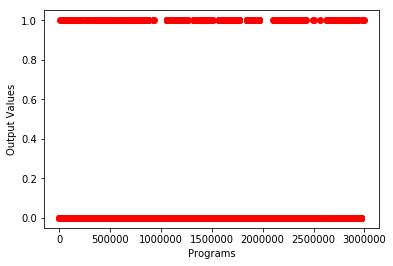

In [7]:
with open("export.txt") as f:
    binary_outputs = list(map(lambda x:(x[0],int(x[1],2)),
                              filter(lambda x:x[1].isdigit(), 
                                     enumerate(map(lambda x: x.strip(), f)))))
    print(list(map(lambda x:x[1],binary_outputs))[:100], " ...")
    binary_output_dict = {x[0]:x[1] for x in binary_outputs}
    
    plt.figure()
    plt.xlabel("Programs")
    plt.ylabel("Output Values")
    plt.plot(list(map(lambda x:x[0],binary_outputs)), 
             list(map(lambda x:x[1],binary_outputs)), 'ro')
    

### A Naive Search For Patterns
If there is clear pattern that describes when these programs will output 0 instead of 1, we may be able to find it with a decision tree. But it seems unlikely that the patterns would exists as dividing lines in size. I would expect for relationships to arise instead by adding a 0 or 1 to the program (2*n or 2*n+1). In any event, we'll see below that the decision tree is pretty much stumped. If would be more surprised if it wasn't.

Feel free to skip this step if it takes too long on your computer.

In [8]:


df=pd.DataFrame(np.array([[k] for k in binary_output_dict]), 
                columns=['index'])
y = list(binary_output_dict.values())

dtree=DecisionTreeClassifier()
dtree.fit(df,y)

dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
display(Image(graph.create_png()))

### The Tree of Programs

Let's look for patterns when adding bits to our programs. This might teach us something interesting about the space.

In [16]:
""" some plumbing for the visualization """

class Tree(object):
    def __init__(self):
        self.left = None
        self.right = None
        self.data = None
    def treelist(self):
        if(self.left and self.right):
            return [self.data] + [self.left.treelist(), 
                                self.right.treelist()]
        return self.data
    
def populate_tree(current_tree, value, num_levels):
    if num_levels == 0:
        current_tree.data = value
        return current_tree
    current_tree.data = value
    current_tree.left = Tree()
    current_tree.right = Tree()
    populate_tree(current_tree.left, 2*value, num_levels-1)
    populate_tree(current_tree.right, 2*value+1, num_levels-1)

def make_vis_graph(tree, root_node, vis_graph, program_output_dict):
    if not (tree.left and tree.right):
        return
    left_data, right_data = tree.left.data, tree.right.data
    left_output = program_output_dict[left_data]
    right_output = program_output_dict[right_data]
    left_node = pydotplus.Node(str(left_data)+' '+str(left_output))
    right_node = pydotplus.Node(str(right_data)+' '+str(right_output))
    vis_graph.add_node(left_node)
    vis_graph.add_node(right_node)
    vis_graph.add_edge(pydotplus.Edge(root_node, left_node))
    vis_graph.add_edge(pydotplus.Edge(root_node, right_node))
    make_vis_graph(tree.left, left_node, vis_graph, program_output_dict)
    make_vis_graph(tree.right, right_node, vis_graph, program_output_dict)

    

Draw the program tree -- notice that the first numbers in each bubble, when converted to binary, are the actual programs we are running. If you see f on the right, it means that program outputted a function.

[1, [2, 4, 5], [3, 6, 7]]


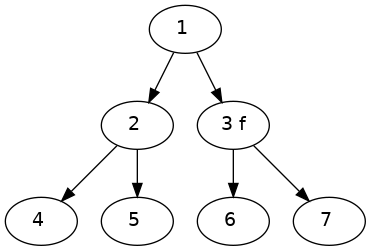

In [17]:
from functools import reduce
def repeated(f,n):
    def rfun(p):
        return reduce(lambda x, _: f(x), range(n), p)
    return rfun

def prettify(program_output):
    if len(program_output) == 0: return program_output
    if program_output.isdigit(): return program_output
    return 'f'

@interact(starting_val='1', num_gens=2)
def draw_program_graph(starting_val=1,num_gens=2):
    starting_val = int(starting_val)
    with open("export.txt") as f:
        program_outputs = list(itertools.islice(enumerate(map(lambda x: x.strip(), f)),
                                                starting_val,
                                                1+repeated(lambda x:2*x+1,num_gens)(starting_val)))
        program_output_dict = {x[0]:x[1] for x in map(lambda x:(x[0],prettify(x[1])),
                                                      program_outputs)}
        root = Tree()
        populate_tree(root,starting_val,num_gens)
        print(root.treelist())

        vis_graph = pydotplus.Dot(graph_type='digraph')
        root_node = pydotplus.Node(str(starting_val)+' '+str(program_output_dict[starting_val]) )
        vis_graph.add_node(root_node)
        make_vis_graph(root, root_node, vis_graph, program_output_dict)
        print(vis_graph)
        #consider augmenting each node w/ # non-empties in its subtree

        display(Image(vis_graph.create_png()))   

Observations: 
Tracing the right-most branch from 1, the output alternates between no output and function.
It looks like we are not looking at programs that are nearly large enough to have any interesting numerical features.

For example, the program to reverse an arbitrary string, when converted to decimal, is:
12587959106914759043661745523835471509447797441348073549038972041554438859694045
19582566928626211732358334423112169229965850832265866950789309120494959158513558
25497698207806449795296223441887214914125084589029501915414124035802567598841207
75754668942290438665225304298097518873230322621098819782461948797043003799254425
0784949042583070624011177497680226900

This is not to say that there are no useful programs that are shorter than that. 
But what this does entail is that from the reverse program, the entire subtree consists of programs that have numerical answers.
.

### Summary
The reason that short programs are interesting to me is that I think of 'understanding' as the process of finding the shortest programs that generate your observations. And while simply searching for short programs can seem untenable on its face, it is in a sense what the scientist does. I would posit that the difference between the above search and the scientist is that the scientist has powerful evolved heuristics for searching through this space. Additionally the scientist already has other programs (generative models) built up that help him along this search.

Indeed, I think the reason that deep learning has found so much success is that we have discovered a small differentiable pocket in the space of programs. What I find interesting is a separate but related proposition. Could we create a programming language such that a bounded change in the program creates a bounded change in its output?

Right now if I take half of a GNU/Linux and half of Windows, and put them together, I get a bunch of meaningless 0's and 1's. We still have no programming language that has anything on DNA. If I change a random bit of a python program, it will crash horribly. But somehow we can mash together the DNA of two parents into babies that are largely viable -- that to me is mind-boggling, and indicative to me that we are doing this whole computation thing wrong.

The best path that I can think of to achieve this is to find patterns in the space of programs, and use those to parameterize the space in such a way that we keep this bounded input bounded output quality. I could see this parameterization being built on top of the universal iota combinator, or coming up with a different universal combinator that directly gives us this feature. The reason that like the notion of using a universal combinator (and not, say, the lambda calculus or SKI) is that enumerating the space of possible programs is convenient, as hopefully I have demonstrated to some degree in this repo.

### Summary 2 -- Reflection
This language is so basic, that it will take an unreasonably long time to find anything interesting. Even though lambda calculus is less fine-grained, it is still Turing complete.
So the difference between these languages is not what programs they can generate, but how far you need to search to find the programs that you care about. They are almost like different bases in the space of programs. 

So it seems reasonable to extrapolate that the best basis to use is the one that generates a desired program set in the least number of steps. It would be interesting to write a program that takes a class of desired programs, and generates an optimal basis language for that class -- ie an optimal set of generating combinators. Then one could find more interesting programs via enumeration much more quickly!   

But how might one effectively specify a set of desirable programs? I might specify a group of programs by specifying properties of categories, like symmetric and monoidal, which tell me how I can draw the wiring diagram describing a function (symmetric says that I can cross wires, and monoidal says that I can run them in parallel). I can go from these kind of properties to an internal language -- for example, cartesian closed categories gives rise to a simply typed lambda calculus.

As for the DNA example, an important distinction is that DNA only pretty much continuous with respect to the being alive property. With respect to general functionality, it is wildly discontinuous -- humans v chimps. The set of programs that we want to specify all have this 'being alive' property, so we pick the DNA basis such that this property exists in most of the short programs. 

So I want to make a program that takes in desired program properties, produces a base language accordingly, and searches in that space. This will make for a fun project! 